In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import multiprocessing
from torch import autograd
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from fastai.torch_imports import *
from pathlib import Path
from itertools import repeat
import tensorboardX
torch.cuda.set_device(3)
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True


/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
DATA_PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
TRAIN_SOURCE_PATH = DATA_PATH/'train'
uid = 'bw2color'

D_MODEL_SAVE_PATH = DATA_PATH/(uid + '_2004_D.h5')
G_MODEL_SAVE_PATH = DATA_PATH/(uid + '_2004_G.h5')
#keep_pct=0.02
keep_pct=1.0
#keep_pct=0.005
#keep_pct=1.0

In [4]:
def get_model_data(image_size: int, batch_size: int, keep_pct: float):
    TRAIN_X_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=True, size=image_size, uid=uid)
    TRAIN_Y_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=False, size=image_size, uid=uid)
    x_paths, y_paths = get_matched_xy_file_lists(TRAIN_X_PATH, TRAIN_Y_PATH)
    x_paths_str = convert_paths_to_str(x_paths)
    y_paths_str = convert_paths_to_str(y_paths)
    print(x_paths_str[:5])
    print(y_paths_str[:5])
    np.random.seed(42)
    keeps = np.random.rand(len(x_paths_str)) < keep_pct
    fnames_x = np.array(x_paths_str, copy=False)[keeps]
    fnames_y = np.array(y_paths_str, copy=False)[keeps]
    val_idxs = get_cv_idxs(len(fnames_x), val_pct=min(0.01/keep_pct, 0.1))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames_x), np.array(fnames_y))
    img_fn = TRAIN_Y_PATH/'n01558993'/'n01558993_9684.JPEG'
    tfms = tfms_from_stats(inception_stats, image_size, tfm_y=TfmType.PIXEL, aug_tfms=transforms_side_on, sz_y=image_size)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=TRAIN_Y_PATH.parent)
    md = ImageData(DATA_PATH, datasets, batch_size, num_workers=16, classes=None)
    return md

In [5]:
md = get_model_data(image_size=224, batch_size=128, keep_pct=keep_pct)
denorm = md.val_ds.denorm

['train_x_bw2color_224/n01440764/n01440764_10026.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10027.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10029.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10040.JPEG', 'train_x_bw2color_224/n01440764/n01440764_10042.JPEG']
['train_y_bw2color_224/n01440764/n01440764_10026.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10027.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10029.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10040.JPEG', 'train_y_bw2color_224/n01440764/n01440764_10042.JPEG']


In [6]:
def generate_denormed_image_pairs(ds: FilesDataset, batches: [(ndarray,ndarray)], idx:int = 0):
    return [(ds.denorm(x)[idx], ds.denorm(y)[idx])for (x,y) in batches]

## EDSR Model

##### TODO:  Also try making the loss/output based on "classification" like in Zhang et al.
##### TODO:  After making unet version- plug that into a Weiserman GAN setup (the discrimator looks at grey image and colorized image, concatenated together via channels).
##### TODO:  Try using higher res images (from FloydHub blog?)
##### TODO:  Try perceptual loss again....
##### TODO:  To convert real old photos, could force them to normal grayscale first.
##### TODO:  Add tensorboard graphs

In [7]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

In [8]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
    def remove(self): 
        self.hook.remove()

In [9]:
class FeatureLoss(nn.Module):
    def __init__(self, block_wgts: [float] = [0.2,0.7,0.1]):
        super().__init__()
        m_vgg = vgg16(True)
        
        blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
        blocks, [m_vgg[i] for i in blocks]
        layer_ids = blocks[:3]
        
        vgg_layers = children(m_vgg)[:23]
        m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
        set_trainable(m_vgg, False)
        
        self.m,self.wgts = m_vgg,block_wgts
        self.sfs = [SaveFeatures(m_vgg[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        res = [F.l1_loss(input,target)/100]
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(input)
        res += [F.l1_loss(self.flatten(inp.features),self.flatten(targ))*wgt
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def flatten(self, x): 
        return x.view(x.size(0), -1)
    
    def close(self):
        for o in self.sfs: o.remove()

In [10]:
def conv(ni, nf, kernel_size=3, actn=False, stride=1, normalizer=None):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2, stride=stride)]
    if normalizer is not None: layers.append(normalizer)
    if actn: layers.append(nn.LeakyReLU())
    return nn.Sequential(*layers)

In [11]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x): return x + self.m(x) * self.res_scale

In [12]:
def res_block_upsample(nf):
    layers = []
    layers.append(conv(nf, nf, actn=True))
    layers.append(conv(nf, nf))
    return ResSequential(layers, 0.1)

In [13]:
class UpSampleBlock(nn.Module):
    def __init__(self, nf, scale=2):
        super().__init__()
        layers = []
        
        for i in range(int(math.log(scale,2))):
            layers += [conv(nf, nf*4), nn.PixelShuffle(2)]
                       
        self.sequence = nn.Sequential(*layers)
        self.icnr_init()
        
    def icnr_init(self):
        conv_shuffle = self.sequence[0][0]
        kernel = icnr(conv_shuffle.weight)
        conv_shuffle.weight.data.copy_(kernel);
    
    def forward(self, x):
        return self.sequence(x)

In [14]:
class ImageModifierModel(nn.Module):
    @staticmethod
    def generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut

    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
    
    def __init__(self):
        super().__init__() 
        rn, lr_cut = ImageModifierModel.generate_base_model()
        self.rn = rn
        set_trainable(rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.up1 = UpSampleBlock(256, 16)  #256 in
        self.up2 = UpSampleBlock(128, 8)  #128 in
        self.up3 = UpSampleBlock(64, 4)    #64 in
        self.up4 = UpSampleBlock(64, 2)   #64 in  
        nf_up = 256+128+64+64
        nf_mid = 128  
 
        mid_layers = []
        mid_layers += [conv(nf_up,nf_mid)]
        for i in range(8): mid_layers.append(res_block_upsample(nf_mid))
        mid_layers += [conv(nf_mid,nf_mid), nn.BatchNorm2d(nf_mid), conv(nf_mid, 3)]
        self.upconv = nn.Sequential(*mid_layers)
             
        out_layers = []
        out_layers += [conv(6, 3, kernel_size=1)]
        self.out = nn.Sequential(*out_layers)
        
    def forward(self, x): 
        self.rn(x)
        x1 = self.up1(self.sfs[3].features)
        x2 = self.up2(self.sfs[2].features)
        x3 = self.up3(self.sfs[1].features)
        x4 = self.up4(self.sfs[0].features) 
        x5 = self.upconv(torch.cat([x1, x2, x3, x4], dim=1))
        return F.tanh(self.out(torch.cat([x, x5], dim=1)))

## WGAN Critic Model

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()   
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [16]:
class Critic2(nn.Module):
    @staticmethod
    def generate_base_model():
        f = resnet34
        cut,lr_cut = model_meta[f]
        layers = cut_model(f(True), cut)
        return nn.Sequential(*layers), lr_cut
    
    def set_trainable(self, trainable):
        set_trainable(self, trainable)
        set_trainable(self.rn, False)
        
    @staticmethod
    def generate_eval_layers(nf_in, nf_mid, sz):
        layers = [] 
        layers.append(ConvBlock(nf_in, nf_mid, 4, 2, bn=False))
        csize,cndf = sz//2,nf_mid
        layers.append(nn.LayerNorm([cndf, csize, csize]))
        layers.append(ConvBlock(cndf, cndf, 3, 1))
        layers.append(nn.LayerNorm([cndf, csize, csize]))

        while csize > 8:
            layers.append(ConvBlock(cndf, cndf*2, 4, 2, bn=False))
            cndf = int(cndf*2)
            csize = int(csize//2)
            layers.append(nn.LayerNorm([cndf, csize, csize]))
        
        layers.append(nn.Conv2d(cndf, 1, 4, padding=0, bias=False))    
        return nn.Sequential(*layers) 
            
    def __init__(self, sz):
        super().__init__()
         
        rn, lr_cut = ImageModifierModel.generate_base_model()
        self.rn = rn
        set_trainable(self.rn, False)
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        
        self.feature_eval_1 = Critic2.generate_eval_layers(256*2, 256, sz//16)
        self.feature_eval_2 = Critic2.generate_eval_layers(128*2, 128, sz//8)
        self.feature_eval_3 = Critic2.generate_eval_layers(64*2, 64, sz//4)
        self.feature_eval_4 = Critic2.generate_eval_layers(64*2, 64, sz//2)     
        self.pixel_eval = Critic2.generate_eval_layers(6, 64, sz)
        
    def forward(self, input, orig):
        self.rn(orig)
        x1 = self.sfs[3].features
        x2 = self.sfs[2].features
        x3 = self.sfs[1].features
        x4 = self.sfs[0].features
        
        self.rn(input)
        y1 = self.sfs[3].features
        y2 = self.sfs[2].features
        y3 = self.sfs[1].features
        y4 = self.sfs[0].features 

        f1 = self.feature_eval_1(torch.cat([x1, y1], dim=1))
        f2 = self.feature_eval_2(torch.cat([x2, y2], dim=1))
        f3 = self.feature_eval_3(torch.cat([x3, y3], dim=1))
        f4 = self.feature_eval_4(torch.cat([x4, y4], dim=1))
  
        p = self.pixel_eval(torch.cat([orig, input], dim=1))
        return f1.mean() + f2.mean() + f3.mean()  + f4.mean() + p.mean()

## Training

In [17]:
#def train(lrs, session_num: int, cycle_len=2, use_clr_beta=(20,10,0.95,0.85)):
#    if session_num > 0:
#        learn.load(uid + '_224_' + str(session_num - 1))
#    learn.fit(lrs, 1, cycle_len=cycle_len, wds=wd, use_clr_beta=use_clr_beta)
#    learn.save(uid + '_224_' + str(session_num))

In [18]:
def visualize(md: ImageData, model: nn.Module, start_idx: int, count: int, figsize=(20,20), max_columns=4):
    end_index = start_idx + count
    idxs = list(range(start_idx,end_index))
    #plot_image_outputs_from_model(md.val_ds, model, list(range(start_idx,end_index)), figsize=figsize, max_columns=max_columns)
    
    image_pairs = []
    ds = md.val_ds

    for idx in idxs:
        x,_=ds[idx]
        preds = model(VV(x[None]))
        image_pairs.append((ds.denorm(x[None])[0], ds.denorm(preds)[0]))
        
    num_pairs = len(image_pairs)
    num_images = num_pairs * 2
    rows, columns = get_num_rows_columns(num_images, max_columns)

    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    for i,(x,y) in enumerate(image_pairs):
        plot_image_from_ndarray(x, axes=axes.flat[i*2])
        plot_image_from_ndarray(y, axes=axes.flat[i*2+1])
        
    display(fig)

In [19]:
wd=1e-7
bs = 16
sz = 128
md = get_model_data(image_size=sz, batch_size=bs, keep_pct=keep_pct)

['train_x_bw2color_128/n01440764/n01440764_10026.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10027.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10029.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10040.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10042.JPEG']
['train_y_bw2color_128/n01440764/n01440764_10026.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10027.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10029.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10040.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10042.JPEG']


In [20]:
netG = ImageModifierModel().cuda()
#load_model(netG, G_MODEL_SAVE_PATH)
netD = Critic2(sz).cuda()
#load_model(netD, D_MODEL_SAVE_PATH)

/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  after removing the cwd from sys.path.
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  after removing the cwd from sys.path.
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  after removing the cwd from sys.path.
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  after removing the cwd from sys.path.


In [21]:
#optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-4)
#optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-4)

#optimizerD = optim.RMSprop(filter(lambda p: p.requires_grad,netD.parameters()), lr = 1e-3)
#optimizerG = optim.RMSprop(filter(lambda p: p.requires_grad,netG.parameters()), lr = 1e-3)

#TODO:  Weird beta 1 value, but we'll see...

optimizerD = optim.Adam(filter(lambda p: p.requires_grad,netD.parameters()), lr=1e-5, betas=(0., 0.9), eps=1e-4)
optimizerG = optim.Adam(filter(lambda p: p.requires_grad,netG.parameters()), lr=1e-5, betas=(0., 0.9), eps=1e-4)

In [22]:
def calc_gradient_penalty(netD, real_data, fake_data, orig_data):
    lamda = 10 # Gradient penalty lambda hyperparameter
    # print "real_data: ", real_data.size(), fake_data.size()
    alpha = torch.rand(bs, 1)
    alpha = alpha.expand(bs, real_data.nelement()//bs).contiguous().view(bs, 3, sz, sz)
    alpha = alpha.cuda()
    differences = fake_data - real_data
    interpolates = real_data + (alpha*differences)
    interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates = netD(interpolates, orig_data)
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lamda
    return gradient_penalty

In [23]:
def progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, ecount):
    if i % 50 == 0:
        print(f'\nWDist {to_np(w_dist)}; GPenalty {to_np(gradient_penalty)}; RScore {to_np(disc_real)};'
          + f' FScore {to_np(disc_fake)}; ECount: {ecount}')

    if i % 500 == 0:
        visualize(md, netG, 500, 8)
        save_model(netD, D_MODEL_SAVE_PATH)
        save_model(netG, G_MODEL_SAVE_PATH)

def is_equilibrium(disc_real, disc_fake):
    if disc_real < disc_fake:
        return False
        
    return abs(disc_real + disc_fake) < (abs(disc_real) + abs(disc_fake))*0.30

def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        n = n-(n%bs)
        with tqdm(total=n) as pbar:
            while i < n:
                netD.set_trainable(True)
                netG.set_trainable(False)
                j = 0
                equilibrium = False
                while (not equilibrium) and (i < n) and j<10000:
                    j += 1; i += 1
                    #or p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    x, y = next(data_iter)
                    orig_image = V(x)
                    real_image = V(y)                        
                    #Higher == Real
                    disc_real = netD(real_image, orig_image)
                    fake_image = netG(orig_image)
                    disc_fake = netD(V(fake_image.data), orig_image)
                    equilibrium = is_equilibrium(disc_real, disc_fake)
                    
                    netD.zero_grad()
                          
                    gradient_penalty = calc_gradient_penalty(netD, real_image.data, fake_image.data, orig_image)              
                    disc_cost = disc_fake - disc_real + gradient_penalty
                    w_dist = disc_fake - disc_real
                    disc_cost.backward()
                    optimizerD.step()
                    pbar.update()
             
                    progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, gen_iterations)

                    
                netD.set_trainable(False)
                netG.set_trainable(True)
                netG.zero_grad()
                
                x, y = next(data_iter)
                orig_image = V(x)
                real_image = V(y)   
                fake_image = netG(orig_image)
                gen_mse_cost = F.mse_loss(fake_image, real_image)
                gen_cost  = -netD(fake_image, orig_image)
                gen_cost .backward()
                optimizerG.step()
                gen_iterations += 1
                
                progress_update(i, w_dist, gradient_penalty, disc_real, disc_fake, md, netG, netD, gen_iterations)

In [24]:
torch.backends.cudnn.benchmark=True

  0%|          | 50/79264 [00:48<20:08:20,  1.09it/s]
WDist -12.789154052734375; GPenalty 4.402767181396484; RScore 6.664949893951416; FScore -6.124204635620117; ECount: 44

WDist -12.789154052734375; GPenalty 4.402767181396484; RScore 6.664949893951416; FScore -6.124204635620117; ECount: 45
  0%|          | 100/79264 [01:35<20:10:10,  1.09it/s]
WDist -28.534198760986328; GPenalty 2.163478374481201; RScore 11.585888862609863; FScore -16.94831085205078; ECount: 94

WDist -28.534198760986328; GPenalty 2.163478374481201; RScore 11.585888862609863; FScore -16.94831085205078; ECount: 95
  0%|          | 150/79264 [02:16<16:46:00,  1.31it/s]
WDist -19.516613006591797; GPenalty 1.209026575088501; RScore 10.435968399047852; FScore -9.080643653869629; ECount: 134

WDist -19.516613006591797; GPenalty 1.209026575088501; RScore 10.435968399047852; FScore -9.080643653869629; ECount: 135
  0%|          | 200/79264 [02:57<19:25:53,  1.13it/s]
WDist -28.807416915893555; GPenalty 0.8744108080863953; RS

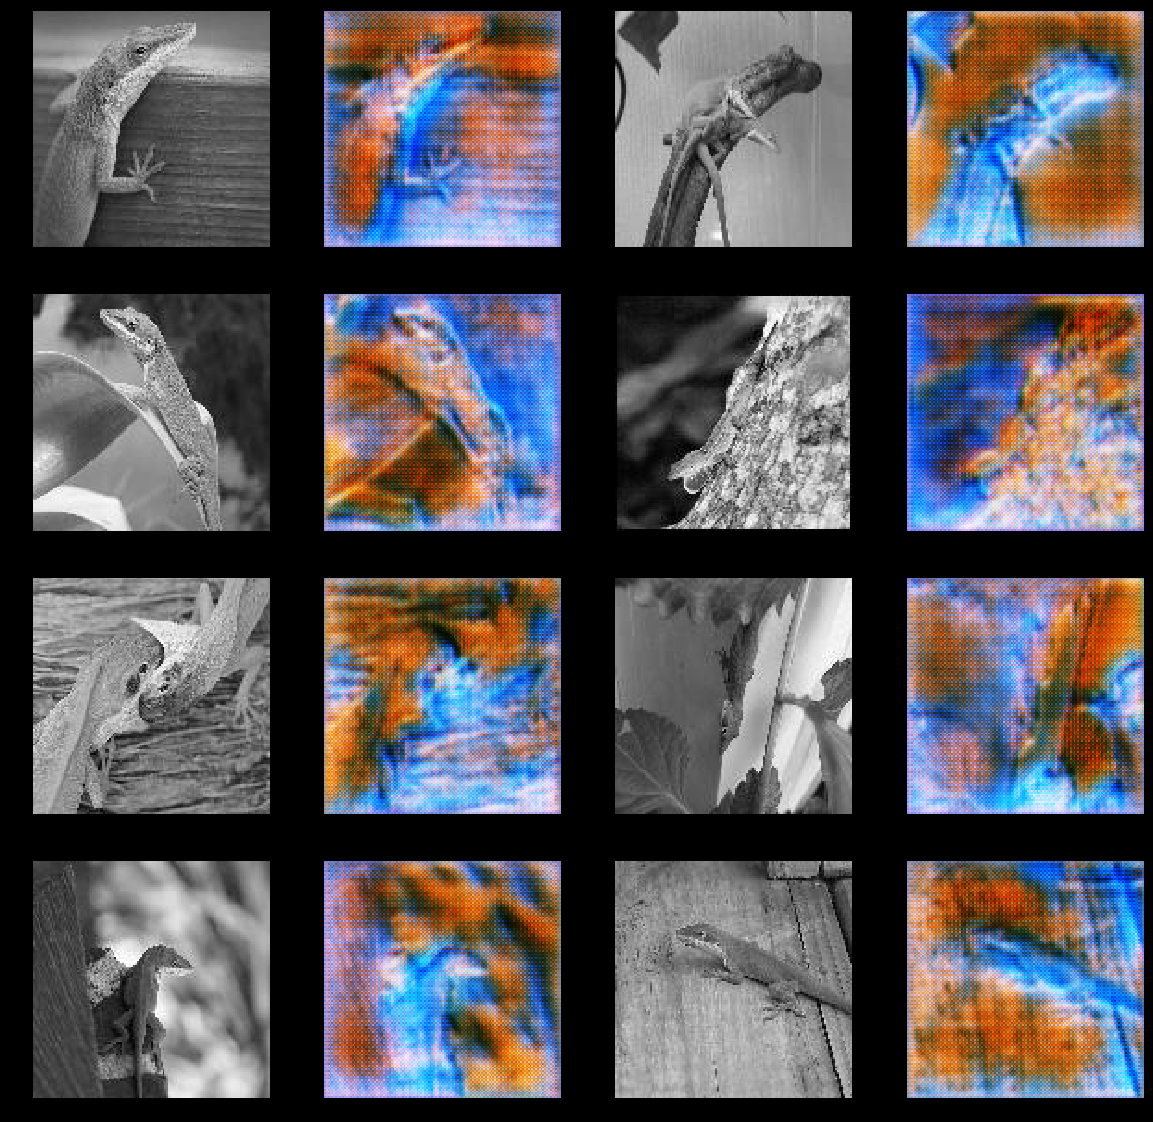


WDist -116.37274932861328; GPenalty 1.74013090133667; RScore 58.96399688720703; FScore -57.40875244140625; ECount: 423


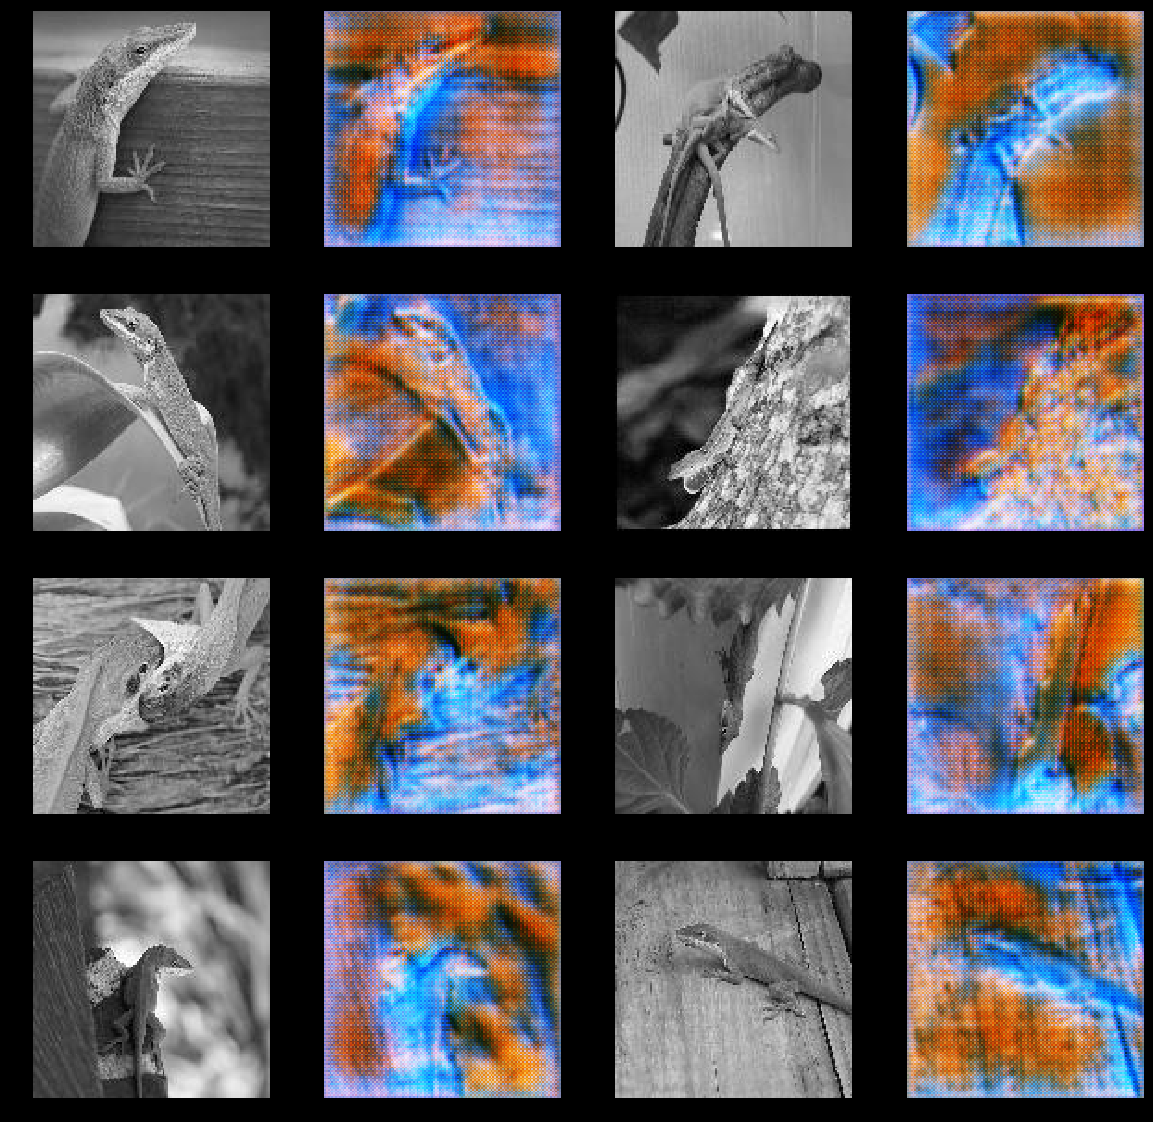

  1%|          | 501/79264 [07:20<61:18:14,  2.80s/it]

In [ ]:
train(1, True)
#train(1, False)

In [ ]:
train(9, False)